In [7]:
import sys
sys.path.append('../scripts')

import proplot as pplt
import pandas as pd
from helpers import *
from scipy import stats
import numpy as np
import random

In [8]:
def parse_data(buoy):
        df = era5_data(buoy)
        df.datetime = df.datetime.astype("datetime64[s]")
        df.index = df.datetime

        dt = pd.Series(df.datetime) - pd.Series(df.datetime).shift()
        dt = dt.dt.total_seconds()

        vx = (df.x_stere - df.x_stere.shift())/dt
        vy = (df.y_stere - df.y_stere.shift())/dt
        v = np.sqrt(vx**2 + vy**2)

        wind_vel = np.sqrt(df['10m_u_wind_mps']**2 + df['10m_v_wind_mps']**2)
        df = df.assign(drift_speed_mps = v, wind_speed_mps=wind_vel, vx= vx, vy=vy)
        return df.dropna()

era5_buoys = [f.split("_")[0] for f in os.listdir("../data/interp_buoys_era5/mosaic_dn1")]
buoy_datas = {}
for buoy in era5_buoys:
    buoy_datas[buoy] = parse_data(buoy)

In [22]:
def jointDistribution(df:pd.DataFrame, 
                      var1:str, 
                      var2:str, 
                      category:str, 
                      cmap : pplt.Colormap,
                      bins : list[int] = [40,40],
                      sample : bool = False):
    vars = df[[var1, var2, category]]
    groups = vars.groupby(category)
    fig, axs = pplt.subplots(ncols=len(groups), figsize=(15,7), sharex=False)

    x_bins = np.linspace(vars[var1].min(), vars[var1].max(), bins[0])
    y_bins = np.linspace(vars[var2].min(), vars[var2].max(), bins[1])

    summaries = []
    min_length = min(len(x[1]) for x in groups)

    for i, group in enumerate(groups):
        title = group[0]
        data = group[1]
        if sample:
            data = data.sample(min_length)

        binned = stats.binned_statistic_2d(data[var1], data[var2], None, "count", bins=[x_bins, y_bins])

        c = axs[i].pcolor(x_bins, y_bins, binned.statistic, cmap=cmap, discrete=False)
        fig.colorbar(c, ax=axs[i])
        axs[i].format(title=f"{category}: {title}", xlocator="linear", xlabel=var1, ylabel=var2)
        overlay = x_bins * 0.015
        axs[i].plot(x_bins, overlay)
        
        summary = {
            f"{var1} mean: ": data[var1].mean(),
            f"{var2} mean: ": data[var2].mean(),
            f"{var1} min: ": data[var1].min(),
            f"{var2} min: ": data[var2].min(),
            f"{var1} max: ": data[var1].max(),
            f"{var2} max: ": data[var2].max(),
            "# Observations: ": len(data)
        }
        summaries.append(pd.DataFrame(summary, index=[str(title)]).transpose())
    print(pd.concat(summaries, axis=1))

,False,True
wind_speed_mps mean:,5.531012,6.456822
drift_speed_mps mean:,0.085788,0.114288
wind_speed_mps min:,0.732393,0.161245
drift_speed_mps min:,0.001255,0.002131
wind_speed_mps max:,12.371649,16.914411
drift_speed_mps max:,0.288060,0.454003
# Observations:,281.000000,1389.000000


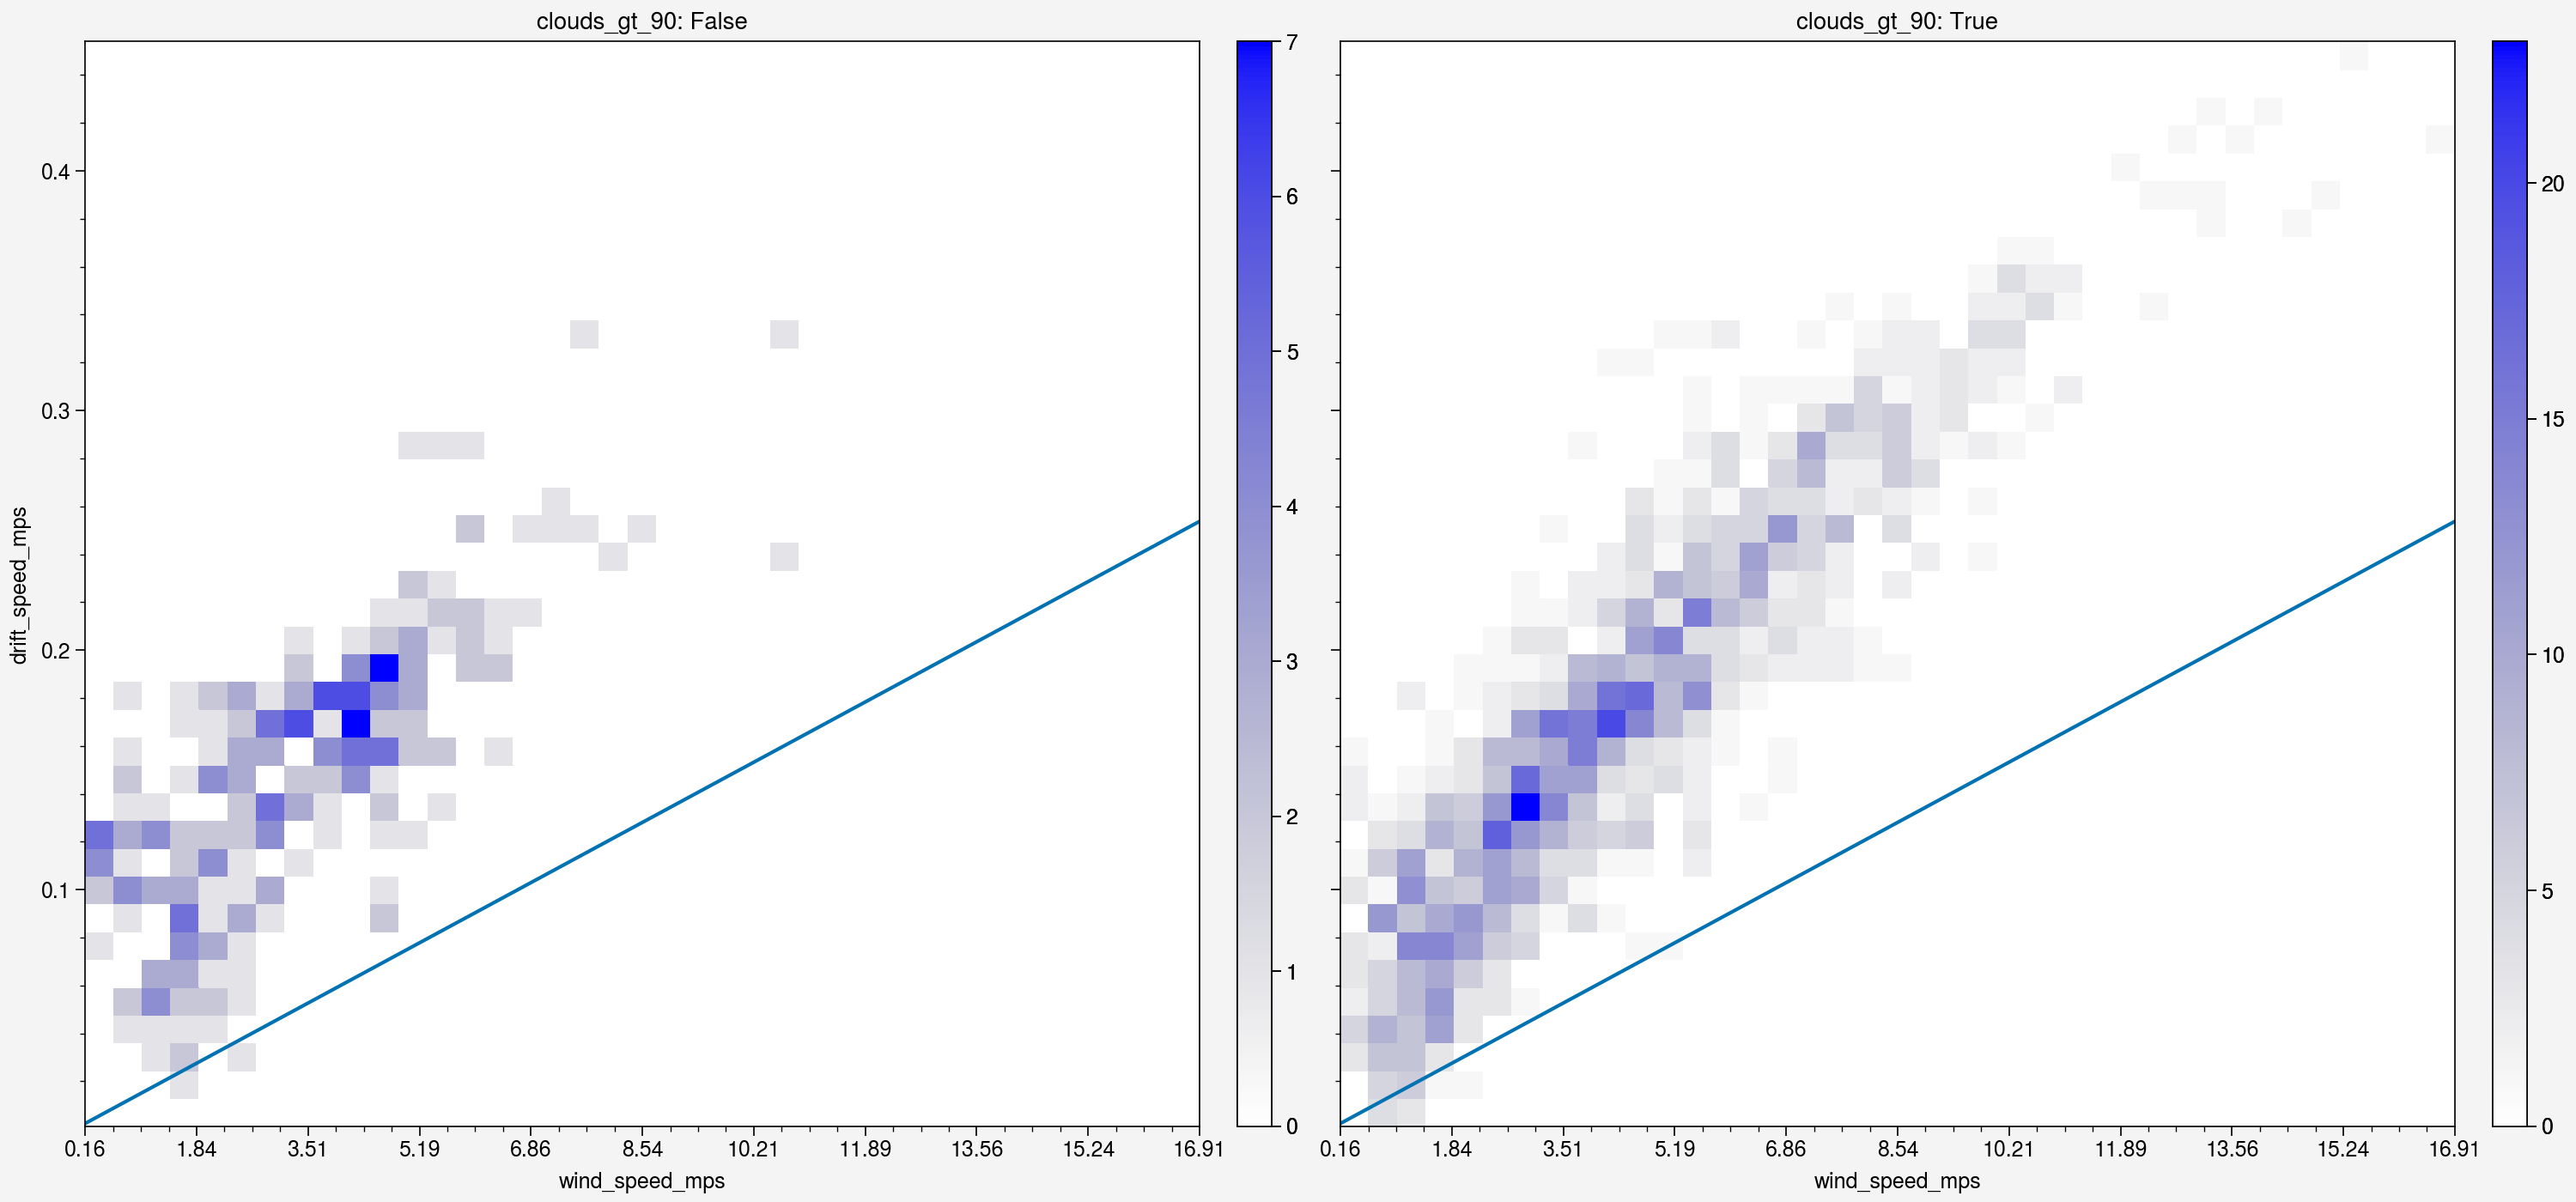

In [23]:
cloud_thresh = 90

df = buoy_datas["2019F4"]

# df = pd.concat(list(buoy_datas.values()))
#df = pd.concat(all[:3])
colormap = pplt.Colormap(["white"]+["blue"])

# df = df[df["wind_speed_mps"] > 6]
kwargs = {f"clouds_gt_{cloud_thresh}" : df.total_cloud_cover > cloud_thresh, "iswinter" : df.datetime < pd.to_datetime("2019-12-02")}
df = df.assign(**kwargs)

jointDistribution(df, "wind_speed_mps", "drift_speed_mps", f"clouds_gt_{cloud_thresh}", colormap, [40, 40])

,False,True
wind_speed_mps mean:,7.474320,5.249083
drift_speed_mps mean:,0.165579,0.111341
wind_speed_mps min:,0.036056,0.022361
drift_speed_mps min:,0.000028,0.000039
wind_speed_mps max:,20.884427,19.563077
drift_speed_mps max:,4.730534,1.905791
# Observations:,371496.000000,372417.000000


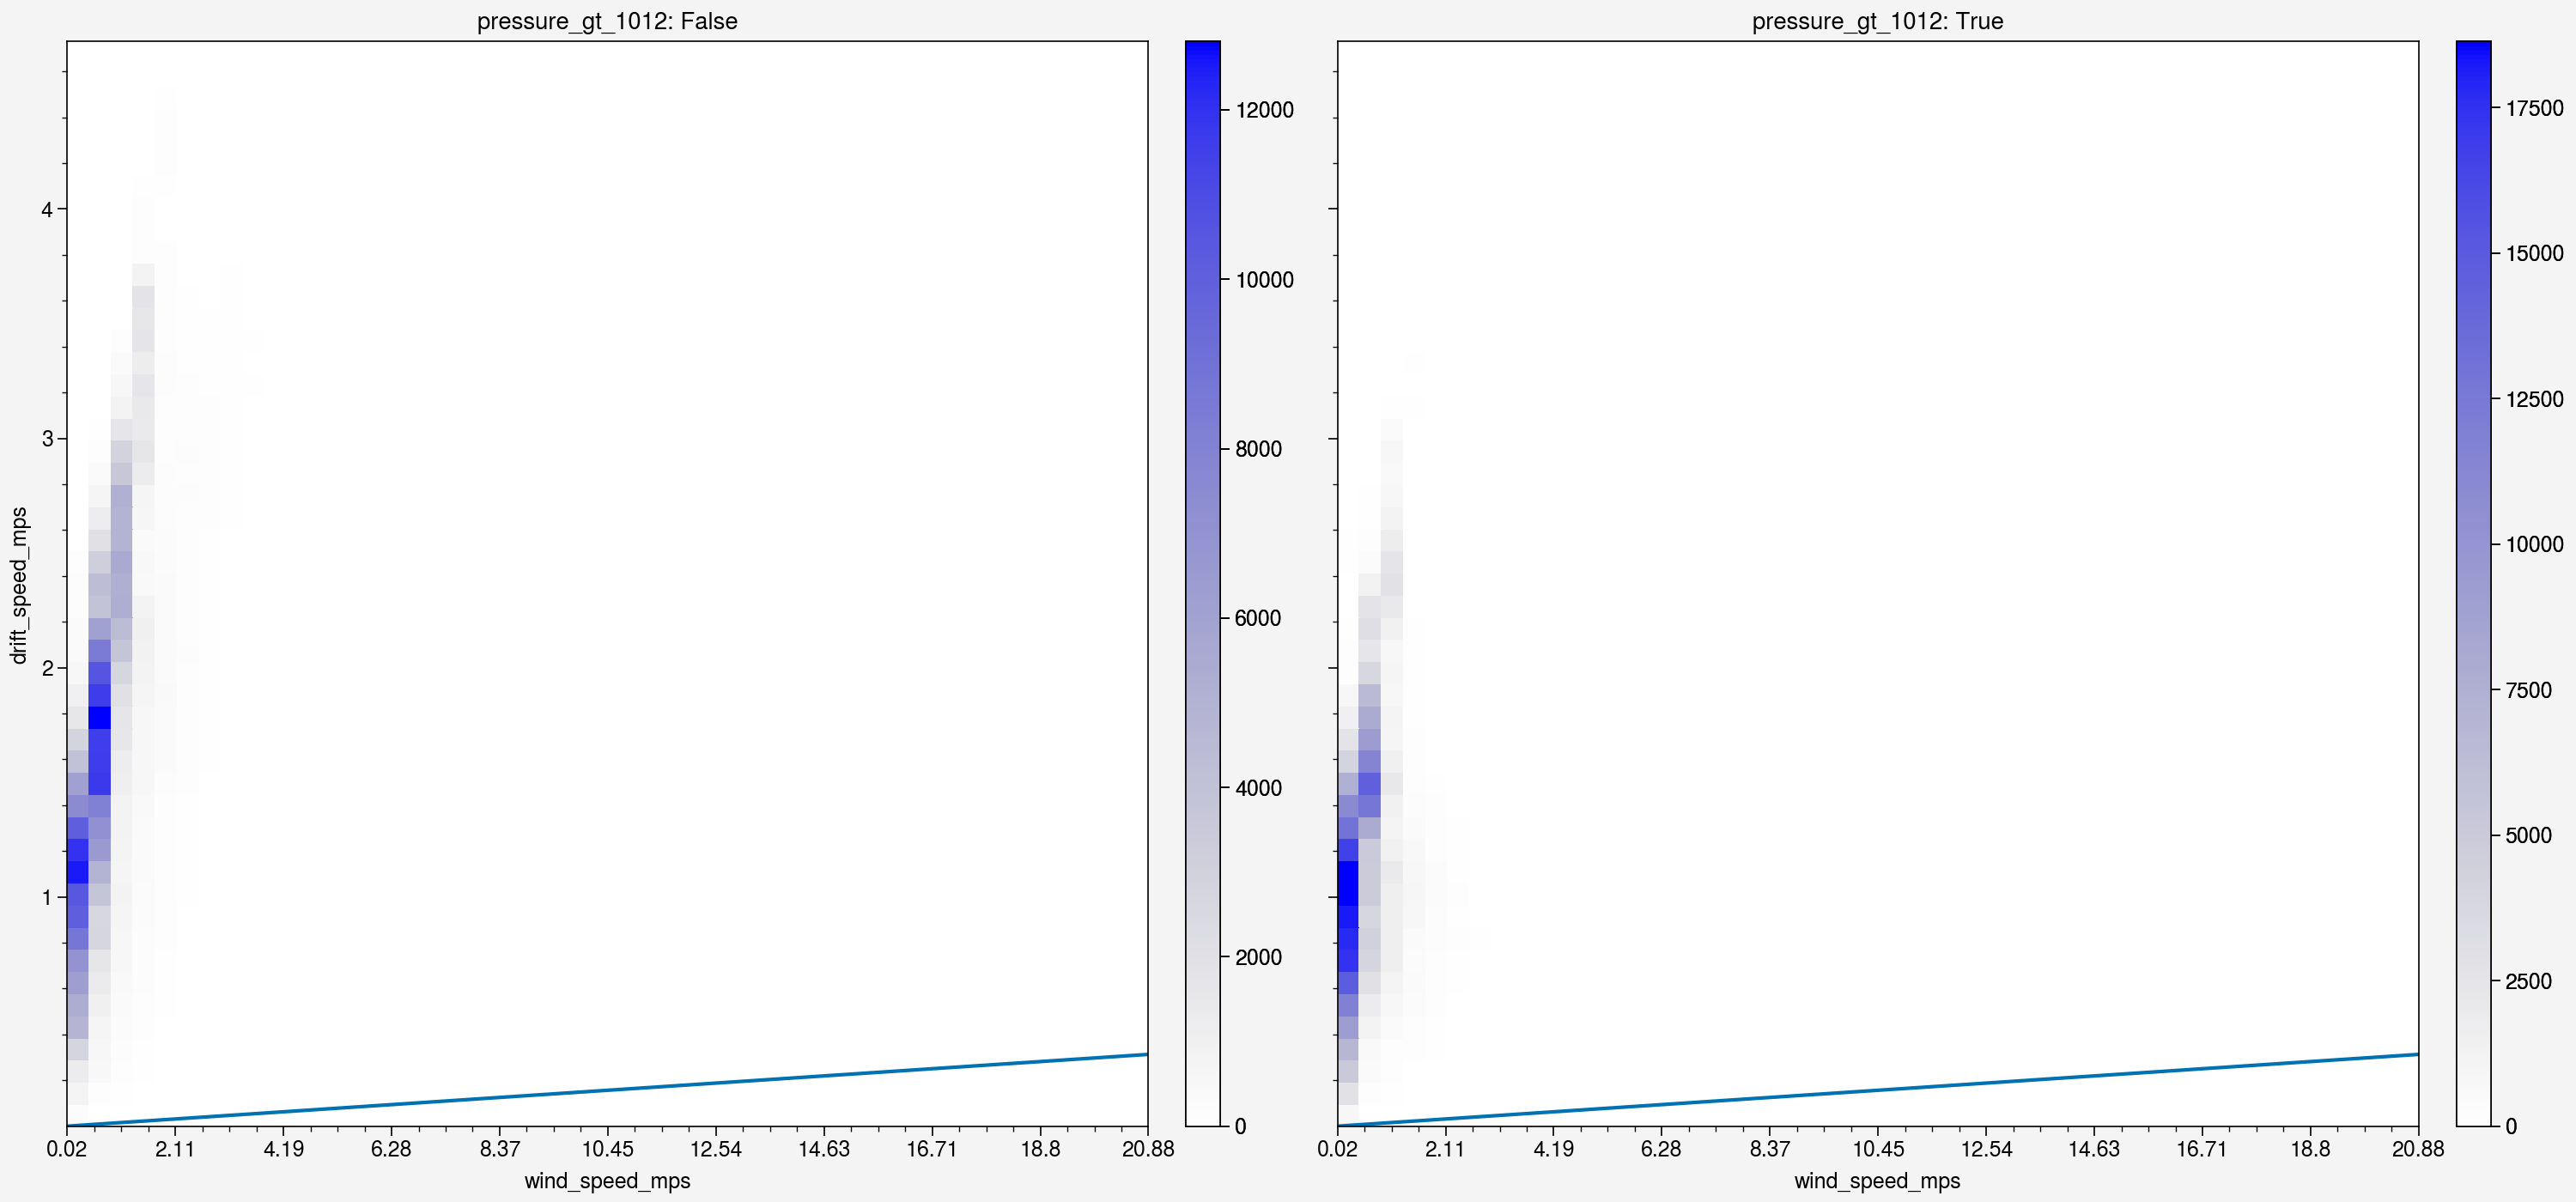

In [ ]:
pressure_thresh = 1012
df = parse_data()
df[f"pressure_gt_{pressure_thresh}"] = df.sea_level_pressure_hpa > pressure_thresh
jointDistribution(df, "wind_speed_mps", "drift_speed_mps", f"pressure_gt_{pressure_thresh}", colormap, [50, 50])